In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

In [2]:
def geo_idx(dd, dd_array):
   """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
   geo_idx = (numpy.abs(dd_array - dd)).argmin()
   return geo_idx

LA_lat = 34.0522
LA_lon = 118.2437 # deg west
LA_lon = 180. + (180-LA_lon)

In [3]:
working_dir = '/ninod/NCAR_LENS/daily/PRECT/B1850C5CN/'

In [4]:
file_list = numpy.array(( \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.04020101-04991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.05000101-05991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.06000101-06991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.07000101-07991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.08000101-08991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.09000101-09991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.10000101-10991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.11000101-11991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.12000101-12991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.13000101-13991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.14000101-14991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.15000101-15991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.16000101-16991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.17000101-17991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.18000101-18991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.19000101-19991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.20000101-20991231.nc', \
'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.21000101-22001231.nc' ))

### Pull out proper lat/lon (doing this for one grid point right now)

In [5]:
d_oct = 31
d_nov = 30
d_dec = 31
d_jan = 31
d_feb = 28
d_mar = 31
days_per_season = d_oct+d_nov+d_dec+d_jan+d_feb+d_mar

In [6]:
i = 0

ncfile = netCDF4.Dataset(working_dir + file_list[i])
PRECT_lat = ncfile.variables['lat'][:]
PRECT_lon = ncfile.variables['lon'][:]
PRECT_time_var = ncfile.variables['time']

PRECT_time_dates = netCDF4.num2date(PRECT_time_var[:], PRECT_time_var.units, PRECT_time_var.calendar)
time_indices_ONDJFM = numpy.array([t.month in [10,11,12,1,2,3] for t in PRECT_time_dates], dtype=bool)
PRECT_time_dates_ONDJFM = PRECT_time_dates[time_indices_ONDJFM]

LA_lat_idx = geo_idx(LA_lat, PRECT_lat)
LA_lon_idx = geo_idx(LA_lon, PRECT_lon)

#PRECT_ONDJFM_CA = ncfile.variables['PRECT'][time_indices_ONDJFM,(LA_lat_idx-2):(LA_lat_idx+2), (LA_lon_idx-2):(LA_lon_idx+2)]*86400.*1000
PRECT_ONDJFM_CA = ncfile.variables['PRECT'][time_indices_ONDJFM,LA_lat_idx, LA_lon_idx]*86400.*1000

In [7]:
# get index of first October
# and index of last March

t=0
while t < PRECT_time_dates_ONDJFM.size:
    if PRECT_time_dates_ONDJFM[t].month!=10:
        t+=1
    else:
        first_October_index = t
        break
t=0
while i < PRECT_time_dates_ONDJFM.size:
    if PRECT_time_dates_ONDJFM[::-1][t].month!=3:
        t+=1
    else:
        last_March_index = PRECT_time_dates_ONDJFM.size-t-1
        break

PRECT_time_dates_ONDJFM_fullseasons = PRECT_time_dates_ONDJFM[first_October_index:last_March_index+1]
PRECT_ONDJFM_CA_fullseasons = PRECT_ONDJFM_CA[first_October_index:last_March_index+1]

years_array = numpy.array(([t.year for t in PRECT_time_dates_ONDJFM_fullseasons]), dtype=numpy.int)
years_array_unique = numpy.unique(years_array)

In [8]:
# subset the full seasons
# subset all other relevant data sets
# loop through time period
# while season is the same

n_seasons = numpy.int(PRECT_time_dates_ONDJFM_fullseasons.size/days_per_season)

threshold=0.1

storm_count=0 # per season
storm_length=0 # for each storm
storm_magnitude=0.0 # for each storm
storm_count_list=[] # for each season
storm_length_list=[] # for each storm, in days
storm_magnitude_list=[] # for each storm, in mm/day

for s in range(n_seasons):
    seas_PRECT = PRECT_ONDJFM_CA_fullseasons[s*days_per_season:(s*days_per_season+days_per_season)]
    for d in range(days_per_season):
        if seas_PRECT[d]>=threshold:
            storm_magnitude+=seas_PRECT[d]
            storm_length+=1 # days
        elif (seas_PRECT[d]<threshold)&(storm_magnitude>0.0):
            storm_magnitude_list.append(storm_magnitude)
            storm_length_list.append(storm_length)
            storm_magnitude=0.0
            storm_length=0
            storm_count+=1
    storm_count_list.append(storm_count)
    storm_count=0

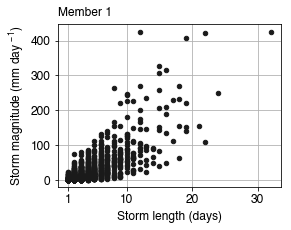

In [9]:
#print(storm_length_list[0:100])
#print(storm_magnitude_list[0:100])
#print(storm_count_list)
fontsize=12

fig = mp.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.scatter(storm_length_list, storm_magnitude_list, s=20, c='0.1')
ax.set_xlabel('Storm length (days)', fontsize=fontsize)
ax.set_ylabel('Storm magnitude (mm day$^{\, -1}$)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.grid()
ax.set_xticks([1,10,20,30])
ax.set_axisbelow(True)
ax.text(s='Member 1', x=0, y=1.05, transform=ax.transAxes, fontsize=fontsize)

mp.savefig('magnitude_vs_length_preindustrial.pdf', transparent=True, bbox_inches='tight')

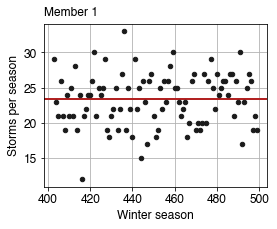

In [10]:
# plot storms per season
fig = mp.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.scatter(years_array_unique[1::], storm_count_list, s=20, c='0.1', zorder=2)
ax.axhline(y=numpy.mean(storm_count_list), lw=2, c='firebrick', zorder=1)
ax.set_xlabel('Winter season', fontsize=fontsize)
ax.set_ylabel('Storms per season', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.text(s='Member 1', x=0, y=1.05, transform=ax.transAxes, fontsize=fontsize)
ax.grid(zorder=0)
ax.set_axisbelow(True)

### All at once now!

b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.04020101-04991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.05000101-05991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.06000101-06991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.07000101-07991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.08000101-08991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.09000101-09991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.10000101-10991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.11000101-11991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.12000101-12991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.13000101-13991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.14000101-14991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.15000101-15991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.16000101-16991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.17000101-17991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.18000101-18991231.nc
b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.19000101-19991231.nc
b.e11.B1

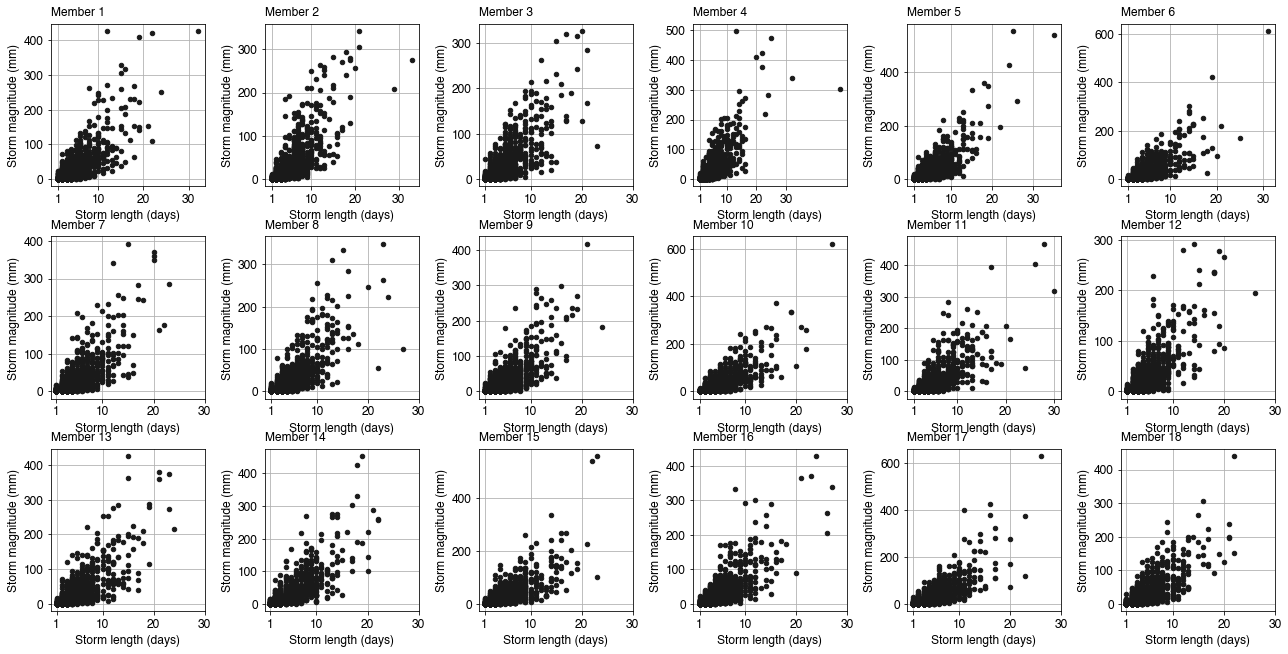

In [7]:
threshold=0.1
fontsize=12

fig = mp.figure(figsize=(18,9))

d_oct = 31
d_nov = 30
d_dec = 31
d_jan = 31
d_feb = 28
d_mar = 31
days_per_season = d_oct+d_nov+d_dec+d_jan+d_feb+d_mar

for i in range(file_list.size):
    print(file_list[i])

    ncfile = netCDF4.Dataset(working_dir + file_list[i])
    PRECT_lat = ncfile.variables['lat'][:]
    PRECT_lon = ncfile.variables['lon'][:]
    PRECT_time_var = ncfile.variables['time']

    PRECT_time_dates = netCDF4.num2date(PRECT_time_var[:], PRECT_time_var.units, PRECT_time_var.calendar)
    time_indices_ONDJFM = numpy.array([t.month in [10,11,12,1,2,3] for t in PRECT_time_dates], dtype=bool)
    PRECT_time_dates_ONDJFM = PRECT_time_dates[time_indices_ONDJFM]

    LA_lat_idx = geo_idx(LA_lat, PRECT_lat)
    LA_lon_idx = geo_idx(LA_lon, PRECT_lon)

    #PRECT_ONDJFM_CA = ncfile.variables['PRECT'][time_indices_ONDJFM,(LA_lat_idx-2):(LA_lat_idx+2), (LA_lon_idx-2):(LA_lon_idx+2)]*86400.*1000
    PRECT_ONDJFM_CA = ncfile.variables['PRECT'][time_indices_ONDJFM,LA_lat_idx, LA_lon_idx]*86400.*1000

    # get index of first October
    # and index of last March

    t=0
    while t < PRECT_time_dates_ONDJFM.size:
        if PRECT_time_dates_ONDJFM[t].month!=10:
            t+=1
        else:
            first_October_index = t
            break
    t=0
    while i < PRECT_time_dates_ONDJFM.size:
        if PRECT_time_dates_ONDJFM[::-1][t].month!=3:
            t+=1
        else:
            last_March_index = PRECT_time_dates_ONDJFM.size-t-1
            break

    PRECT_time_dates_ONDJFM_fullseasons = PRECT_time_dates_ONDJFM[first_October_index:last_March_index+1]
    PRECT_ONDJFM_CA_fullseasons = PRECT_ONDJFM_CA[first_October_index:last_March_index+1]

    years_array = numpy.array(([t.year for t in PRECT_time_dates_ONDJFM_fullseasons]), dtype=numpy.int)
    years_array_unique = numpy.unique(years_array)

    n_seasons = numpy.int(PRECT_time_dates_ONDJFM_fullseasons.size/days_per_season)

    storm_count=0 # per season
    storm_length=0 # for each storm
    storm_magnitude=0.0 # for each storm
    storm_count_list=[] # for each season
    storm_length_list=[] # for each storm, in days
    storm_magnitude_list=[] # for each storm, in mm/day

    for s in range(n_seasons):
        seas_PRECT = PRECT_ONDJFM_CA_fullseasons[s*days_per_season:(s*days_per_season+days_per_season)]
        for d in range(days_per_season):
            if seas_PRECT[d]>=threshold:
                storm_magnitude+=seas_PRECT[d]
                storm_length+=1 # days
            elif (seas_PRECT[d]<threshold)&(storm_magnitude>0.0):
                storm_magnitude_list.append(storm_magnitude)
                storm_length_list.append(storm_length)
                storm_magnitude=0.0
                storm_length=0
                storm_count+=1
        storm_count_list.append(storm_count)
        storm_count=0

    ax = fig.add_subplot(3,6,i+1)
    ax.scatter(storm_length_list, storm_magnitude_list, s=20, c='0.1')
    ax.set_xlabel('Storm length (days)', fontsize=fontsize)
    ax.set_ylabel('Storm magnitude (mm)', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.grid()
    ax.set_xticks([1,10,20,30])
    ax.set_axisbelow(True)
    ax.text(s='Member '+str(i+1), x=0, y=1.05, transform=ax.transAxes, fontsize=fontsize)

mp.tight_layout(w_pad=1.0)
mp.savefig('magnitude_vs_length_preindustrial_allmembers_panel.pdf', transparent=True, bbox_inches='tight')

In [ ]:
bins = numpy.logspace(-2,numpy.log10(PRECT_ONDJFM_CA.max()),100) # log spaced bins
#bins = numpy.linspace(0.1,PRECT_ONDJFM_CA.max(),100) # linearly spaced bins
hist_histogram, bin_edges = numpy.histogram(PRECT_ONDJFM_CA, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = numpy.diff(bin_edges) # same as bin_edges[1:]-bin_edges[:-1]

In [ ]:
fig = mp.figure(figsize=(3,3))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.25', label='historical')
#ax.set_xlim(bins[0], bins[-1])
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('Events (days)', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm day$^{-1}$)', fontsize=fontsize)
ax.set_yscale('log') # 'symlog'
ax.set_xticks([0,25,50,75,100,125,150])
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.minorticks_off()
#ax.grid()
ax.set_axisbelow(True)

ax.set_ylim(0.5,3000)
#ax_right = ax.twinx()
ax_min, ax_max = ax.get_ylim()
#ax_right.set_yticks([1,2,3,4,5,10])
#ax_right.tick_params(labelsize=fontsize)
#ax_right.set_ylim(numpy.log(ax_min), numpy.log(ax_max))

perc50 = numpy.percentile(PRECT_ONDJFM_CA, 50)
perc75 = numpy.percentile(PRECT_ONDJFM_CA, 75)
perc80 = numpy.percentile(PRECT_ONDJFM_CA, 80)
perc90 = numpy.percentile(PRECT_ONDJFM_CA, 90)
perc95 = numpy.percentile(PRECT_ONDJFM_CA, 95)
perc99 = numpy.percentile(PRECT_ONDJFM_CA, 99)
perc999 = numpy.percentile(PRECT_ONDJFM_CA, 99.9)

perc_text = \
'{:.1f}'.format(perc90) + ' (90th)\n' + \
'{:.1f}'.format(perc95) + ' (95th)\n' + \
'{:.1f}'.format(perc99) + ' (99th)\n' + \
'{:.1f}'.format(perc999) + ' (99.9th)\n' + \
'mm day$^{-1}$'

ax.text(s=perc_text, x=0.96, y=0.93, transform=ax.transAxes, ha='right', va='top', fontsize=fontsize)

fig.tight_layout()

mp.savefig('single_realization_preindustrial.pdf', transparent=True, bbox_inches='tight')

In [ ]:
fig = mp.figure(figsize=(18,9))
fontsize=12

for i in range(file_list.size):
    
    print(file_list[i])
    
    ncfile = netCDF4.Dataset(working_dir + file_list[i])
    PRECT = ncfile.variables['PRECT'][:,(LA_lat_idx-2):(LA_lat_idx+2),(LA_lon_idx-2):(LA_lon_idx+2)]*86400.*1000
    PRECT_time_var = ncfile.variables['time']
    
    PRECT_time_dates = netCDF4.num2date(PRECT_time_var[:], PRECT_time_var.units, PRECT_time_var.calendar)
    time_indices_ONDJFM = numpy.array([t.month in [10,11,12,1,2,3] for t in PRECT_time_dates], dtype=bool)
    #PRECT_ONDJFM = PRECT[time_indices_ONDJFM,:,:]
    PRECT_ONDJFM_CA = PRECT[time_indices_ONDJFM,:,:]

    ncfile.close()
    
    bins = numpy.logspace(-2,numpy.log10(PRECT_ONDJFM_CA.max()),100) # log spaced bins
    #bins = numpy.linspace(0.1,PRECT_ONDJFM_CA.max(),100) # linearly spaced bins
    hist_histogram, bin_edges = numpy.histogram(PRECT_ONDJFM_CA, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bin_width = numpy.diff(bin_edges) # same as bin_edges[1:]-bin_edges[:-1]

    ax = fig.add_subplot(3,6,i+1)
    ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.25', label='historical')
    #ax.set_xlim(bins[0], bins[-1])
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('Events (days)', fontsize=fontsize)
    ax.set_xlabel('Precipitation (mm day$^{-1}$)', fontsize=fontsize)
    ax.set_yscale('log') # 'symlog'
    ax.set_xticks([0,25,50,75,100,125,150])
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax.set_ylim(0.5,3000)
    ax.minorticks_off()
    #ax.grid()
    #ax.set_axisbelow(True)

    perc90 = numpy.percentile(PRECT_ONDJFM_CA, 90)
    perc95 = numpy.percentile(PRECT_ONDJFM_CA, 95)
    perc99 = numpy.percentile(PRECT_ONDJFM_CA, 99)
    perc999 = numpy.percentile(PRECT_ONDJFM_CA, 99.9)

    perc_text = \
    '{:.1f}'.format(perc90) + ' (90th)\n' + \
    '{:.1f}'.format(perc95) + ' (95th)\n' + \
    '{:.1f}'.format(perc99) + ' (99th)\n' + \
    '{:.1f}'.format(perc999) + ' (99.9th)\n' + \
    'mm day$^{-1}$'

    ax.text(s=perc_text, x=0.96, y=0.93, transform=ax.transAxes, ha='right', va='top', fontsize=fontsize)

    ax.text(s='Member '+str(i+1), x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize)
fig.tight_layout()

fig.tight_layout()
mp.savefig('preindustrial_control_histograms.pdf', transparent=True, bbox_inches='tight')

In [ ]:
print(ax_min, ax_max)